In [4]:
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
df = pd.read_csv("data/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv")
df.head()


,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


In [6]:
df.replace(-99.90, np.nan, inplace=True)
df.drop('Date/Time',axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,0.763,1.15,4.520,5.513,49.0,25.65
1,0.770,1.41,4.582,5.647,75.0,25.50
2,0.747,1.16,4.515,5.083,91.0,25.45
3,0.718,1.61,4.614,6.181,68.0,25.45
4,0.707,1.34,4.568,4.705,73.0,25.50


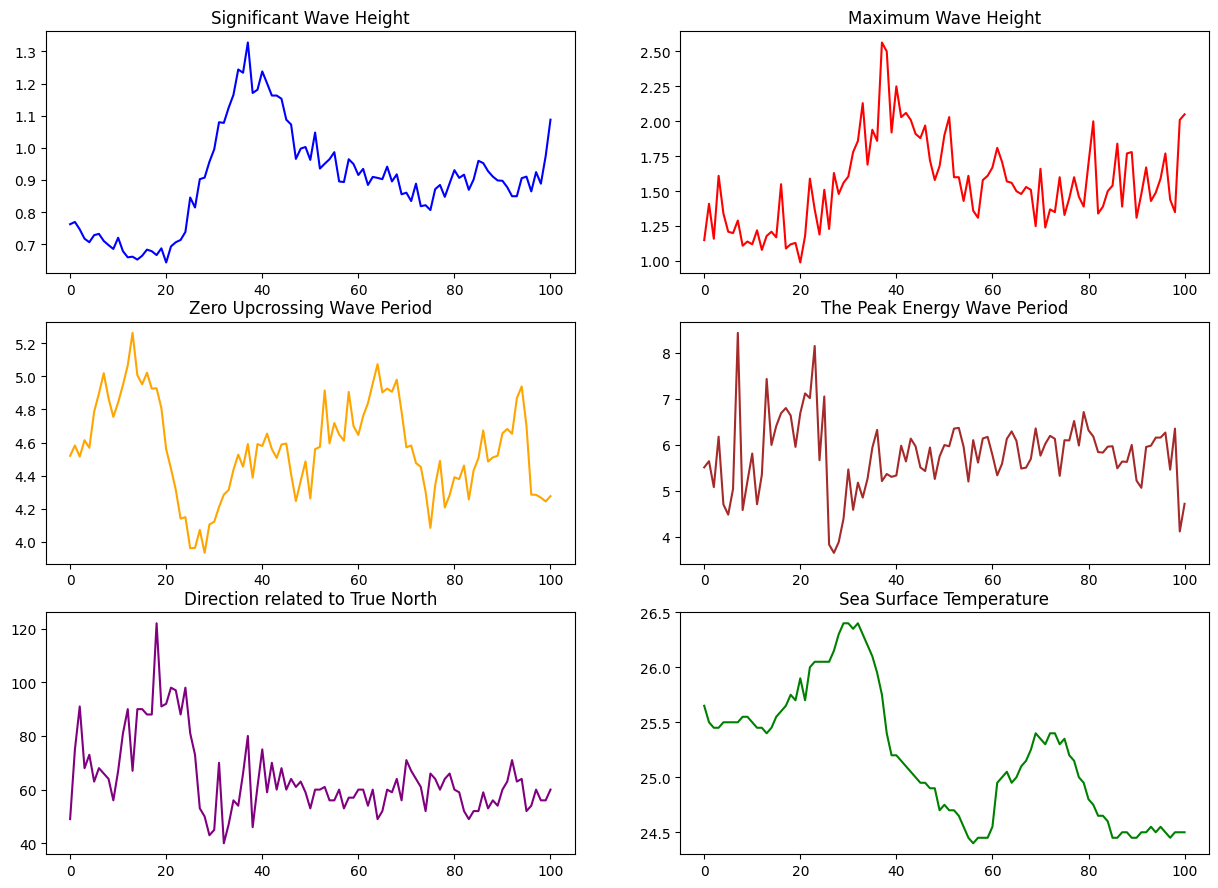

In [7]:
df_graph = df.loc[0:100]

plt.figure(figsize=(15,22))
plt.subplot(6,2,1)
plt.plot(df_graph['Hs'],color='blue')
plt.title('Significant Wave Height')

plt.subplot(6,2,2)
plt.plot(df_graph['Hmax'],color='red')
plt.title('Maximum Wave Height')

plt.subplot(6,2,3)
plt.plot(df_graph['Tz'],color='orange')
plt.title("Zero Upcrossing Wave Period")

plt.subplot(6,2,4)
plt.plot(df_graph['Tp'],color='brown')
plt.title("The Peak Energy Wave Period")

plt.subplot(6,2,5)
plt.plot(df_graph['Peak Direction'],color='purple')
plt.title("Direction related to True North")

plt.subplot(6,2,6)
plt.plot(df_graph['SST'],color='green')
plt.title("Sea Surface Temperature")
plt.show()

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43454 entries, 0 to 43453
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              43454 non-null  float64
 1   Hmax            43454 non-null  float64
 2   Tz              43454 non-null  float64
 3   Tp              43454 non-null  float64
 4   Peak Direction  43454 non-null  float64
 5   SST             43454 non-null  float64
dtypes: float64(6)
memory usage: 2.0 MB
None


In [9]:
df.describe()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
count,43454.000000,43454.000000,43454.000000,43454.000000,43454.000000,43454.000000
mean,1.237799,2.090125,5.619685,9.011972,98.626594,23.949641
std,0.528608,0.897640,0.928533,2.390107,24.275165,2.231022
min,0.294000,0.510000,3.076000,2.720000,5.000000,19.800000
25%,0.839000,1.410000,4.981000,7.292000,85.000000,21.900000
50%,1.130000,1.900000,5.530000,8.886000,101.000000,23.950000
75%,1.544000,2.600000,6.166000,10.677000,116.000000,26.050000
max,4.257000,7.906000,10.921000,21.121000,358.000000,28.650000


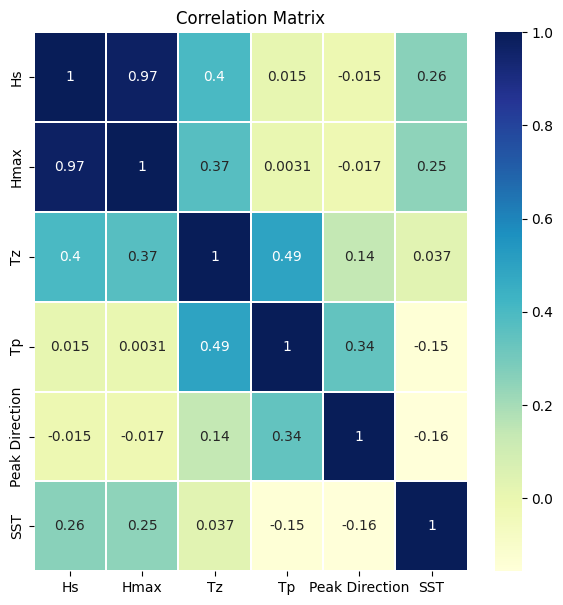

In [10]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(),linewidth=.1,annot=True,cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

#Scaling all values between 1 and 0
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(df)
print('Shape of the scaled data matrix: ',data.shape)

Shape of the scaled data matrix:  (43454, 6)


In [12]:
data[0]

array([0.11834469, 0.08653326, 0.18406628, 0.15178523, 0.12464589,
       0.66101695])

In [13]:
#Train Test Split

train = data[:42000,]
test = data[42000: ,]

#Check the shapes of the datasets
print('Shape of train data: ',train.shape)
print('Shape of test data: ',test.shape)

Shape of train data:  (42000, 6)
Shape of test data:  (1454, 6)


In [14]:

def create_dataset(dataset,lookback):
    """
    Transform the dataset array into a torch tensor
    """
    X_, y_ = [],[]
    for i in range(len(dataset) - lookback - 1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback+1]
        X_.append(feature)
        y_.append(target)
        
    X = np.array(X_)
    X = np.reshape(X,(X.shape[0],X.shape[2],X.shape[1]))
    y = np.array(y_)
    return torch.tensor(X,dtype=torch.float32),torch.tensor(y,dtype=torch.float32)

In [15]:
lookback = 30

X_train, y_train = create_dataset(train,lookback)
X_test,y_test = create_dataset(test,lookback)

print(f'X_train shape: {X_train.shape} , y_train shape :{y_train.shape}')
print('X_test shape :',X_test.shape, ' y_test shape: ',y_test.shape)

X_train shape: torch.Size([41969, 6, 30]) , y_train shape :torch.Size([41969, 6])
X_test shape : torch.Size([1423, 6, 30])  y_test shape:  torch.Size([1423, 6])


In [16]:
(X_train.shape[1],X_train.shape[2])

(6, 30)

In [17]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset

class WaveLSTM(nn.Module):
    def __init__(self, input_dim,hidden_dim1=32,hidden_dim2=16,hidden_dim3=10,output_dim=6,dropout=0.2):
        super(WaveLSTM,self).__init__()
        self.lstm1 = nn.LSTM(input_dim,hidden_dim1,batch_first=True,bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_dim1,hidden_dim2,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(hidden_dim2,hidden_dim3,batch_first=True)
        self.fc = nn.Linear(hidden_dim3,output_dim)
        
    def forward(self,x):
        out,_ = self.lstm1(x)
        out,_ = self.lstm2(out)
        out = self.dropout(out)
        out,_ = self.lstm3(out)
        out = self.fc(out[:, -1, :]) #Using the last time's step's out for the dense layer
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 30

model = WaveLSTM(input_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

batch_size = 200
train_dataset = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = TensorDataset(X_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

num_epochs = 100
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X,batch_y = batch_X.to(device),batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions,batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
    
    model.eval()
    with torch.inference_mode():
        total_test_loss = 0.0
        
        for batch_X_test,batch_y_test in test_loader:
            batch_X_test,batch_y_test = batch_X_test.to(device),batch_y_test.to(device)
            test_pred = model(batch_X_test)
            test_loss = loss_fn(test_pred,batch_y_test)
            
            total_test_loss += test_loss.item()
        
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    
    print(f"Epoch[{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss}")



Epoch[1/100] - Training Loss: 0.0385, Test Loss: 0.013924243045039475
Epoch[2/100] - Training Loss: 0.0070, Test Loss: 0.006440458499127999
Epoch[3/100] - Training Loss: 0.0043, Test Loss: 0.004522444694885053
Epoch[4/100] - Training Loss: 0.0034, Test Loss: 0.003767979156691581
Epoch[5/100] - Training Loss: 0.0030, Test Loss: 0.0033933863160200417
Epoch[6/100] - Training Loss: 0.0027, Test Loss: 0.0031538459297735244
Epoch[7/100] - Training Loss: 0.0025, Test Loss: 0.003028018501936458
Epoch[8/100] - Training Loss: 0.0024, Test Loss: 0.0029554777429439127
Epoch[9/100] - Training Loss: 0.0023, Test Loss: 0.0029162769351387396
Epoch[10/100] - Training Loss: 0.0023, Test Loss: 0.002855049562640488
Epoch[11/100] - Training Loss: 0.0022, Test Loss: 0.002923601379734464
Epoch[12/100] - Training Loss: 0.0022, Test Loss: 0.002788824829622172
Epoch[13/100] - Training Loss: 0.0021, Test Loss: 0.0027824215649161488
Epoch[14/100] - Training Loss: 0.0021, Test Loss: 0.002803157563903369
Epoch[15/1

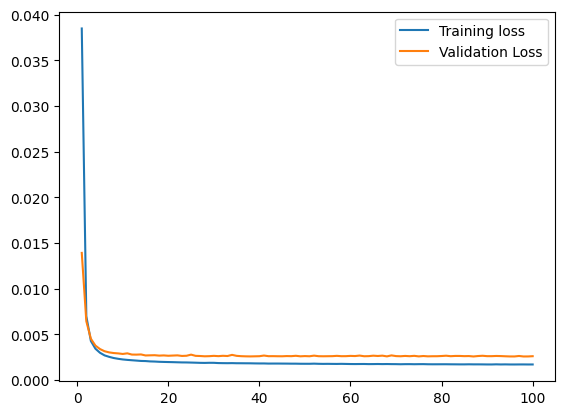

In [18]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True,label="Training loss")
plt.plot(x,test_hist,label="Validation Loss")
plt.legend()
plt.show()

In [19]:
#MAKING PREDICTIONS


# Define the function for predictions
def predicting(model, data, y_real, scaler):
    # Set the model to evaluation mode
    model.eval()
    
    # Ensure no gradients are calculated during inference
    with torch.no_grad():
        # Perform prediction
        predicted_data = model(data)
    
    # Invert scaling process to get the original value ranges
    predicted_data = scaler.inverse_transform(predicted_data.numpy())
    y_real = scaler.inverse_transform(y_real.numpy())
    
    return predicted_data, y_real

# Execute predictions
train_prediction, y_train_scaled = predicting(model, X_train, y_train, scaler)
test_prediction, y_test_scaled = predicting(model, X_test, y_test, scaler)


In [ ]:
print(train_prediction.shape,predictions.shape)

(41969, 6) torch.Size([169, 6])


tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])

In [21]:
import math 
from sklearn.metrics import mean_squared_error

def examine_rmse(y_true,y_pred):
    Score_Hs = math.sqrt(mean_squared_error(y_true[:,0],   y_pred[:,0]))
    Score_Hmax = math.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))
    Score_Tz = math.sqrt(mean_squared_error(y_true[:,2],   y_pred[:,2]))
    Score_Tp = math.sqrt(mean_squared_error(y_true[:,3],   y_pred[:,3]))
    Score_Dir = math.sqrt(mean_squared_error(y_true[:,4],  y_pred[:,4]))
    Score_SST = math.sqrt(mean_squared_error(y_true[:,5],  y_pred[:,5]))
    
    print('RMSE_Hs       : ', Score_Hs)
    print('RMSE_Hmax     : ', Score_Hmax)
    print('RMSE_Tz       : ', Score_Tz)
    print('RMSE_Tp       : ', Score_Tp)
    print('RMSE_Direction: ', Score_Dir)
    print('RMSE_SST      : ', Score_SST)

In [22]:
# Executing the RMSE comparison
print('Trainin Data Errors')
print(examine_rmse(train_prediction, y_train_scaled),'\n')
print('Test Data Errors')
print(examine_rmse(test_prediction, y_test_scaled))

Trainin Data Errors
RMSE_Hs       :  0.0865888269916891
RMSE_Hmax     :  0.2508233341070088
RMSE_Tz       :  0.2954981144878822
RMSE_Tp       :  1.2629454704951009
RMSE_Direction:  11.841702004866965
RMSE_SST      :  0.11161133230384407
None 

Test Data Errors
RMSE_Hs       :  0.07881181242372133
RMSE_Hmax     :  0.23662064316502396
RMSE_Tz       :  0.3092440140028428
RMSE_Tp       :  1.9375099058820926
RMSE_Direction:  13.396406779416985
RMSE_SST      :  0.12290482041351725
None


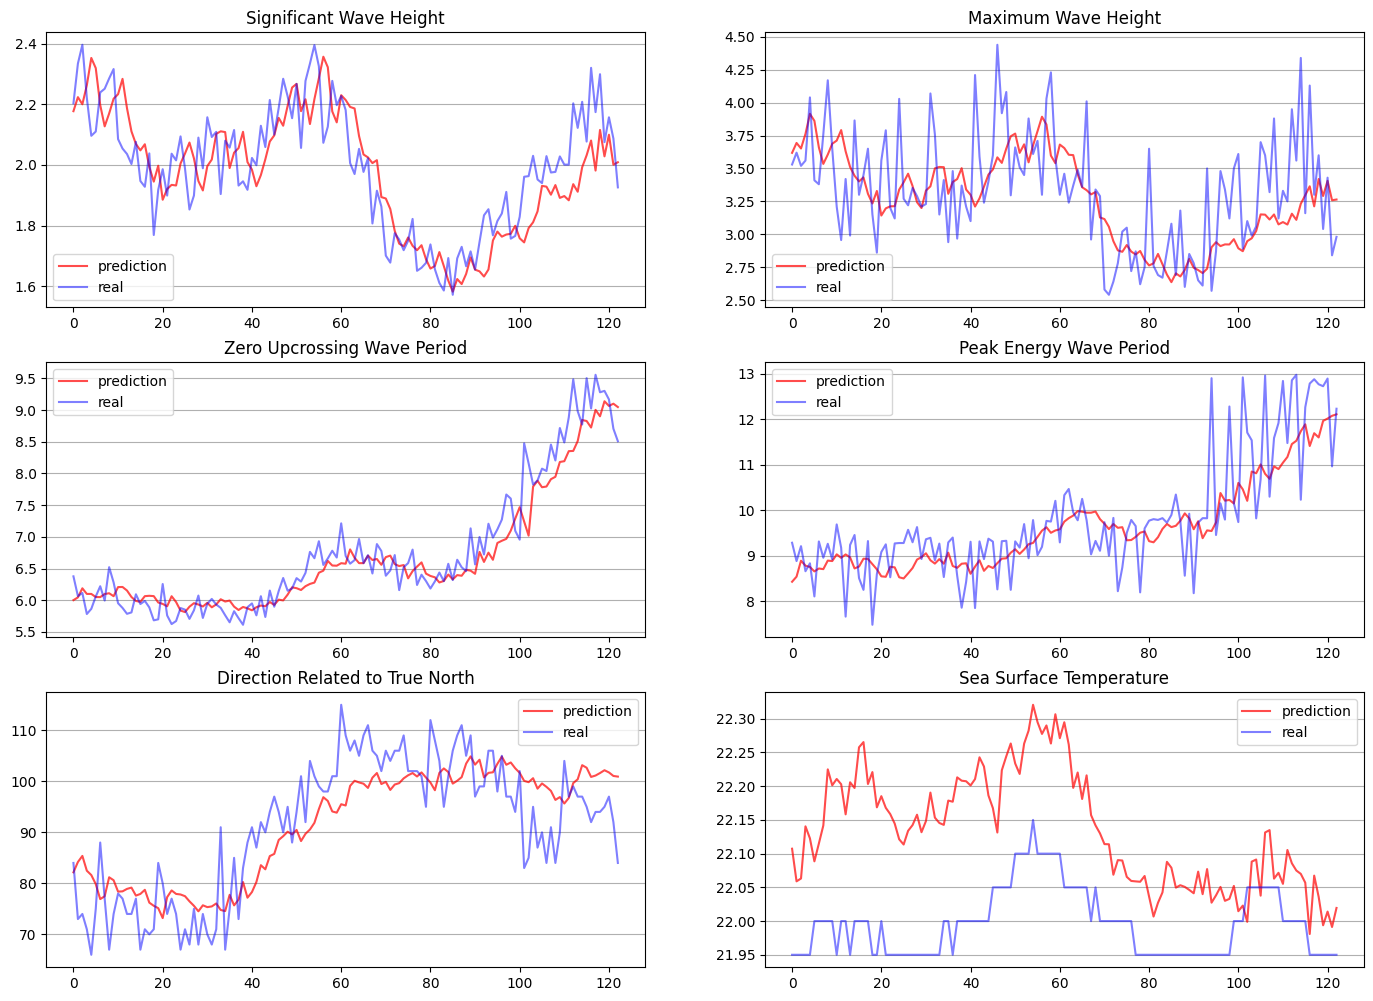

In [23]:
plt.figure(figsize=(17,25))


plt.subplot(6,2,1)
plt.plot(test_prediction[1300:,0], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,0], color='blue', alpha=0.5, label='real')
plt.title('Significant Wave Height')
plt.legend()
plt.grid(axis='y')

plt.subplot(6,2,2)
plt.plot(test_prediction[1300:,1], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,1], color='blue', alpha=0.5, label='real')
plt.title('Maximum Wave Height')
plt.legend()
plt.grid(axis='y')

plt.subplot(6,2,3)
plt.plot(test_prediction[1300:,2], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,2], color='blue', alpha=0.5, label='real')
plt.title('Zero Upcrossing Wave Period')
plt.legend()
plt.grid(axis='y')

plt.subplot(6,2,4)
plt.plot(test_prediction[1300:,3], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,3], color='blue', alpha=0.5, label='real')
plt.title('Peak Energy Wave Period')
plt.legend()
plt.grid(axis='y')

plt.subplot(6,2,5)
plt.plot(test_prediction[1300:,4], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,4], color='blue', alpha=0.5, label='real')
plt.title('Direction Related to True North')
plt.legend()
plt.grid(axis='y')

plt.subplot(6,2,6)
plt.plot(test_prediction[1300:,5], color='red', alpha=0.7, label='prediction')
plt.plot(y_test_scaled[1300:,5], color='blue', alpha=0.5, label='real')
plt.title('Sea Surface Temperature')
plt.legend()
plt.grid(axis='y')
plt.show();


### Saving the model

In [24]:
from pathlib import Path

MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

#Create model save path
MODEL_NAME = "ocean_wave_lstm.pth"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME

#Save the state dict
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)